In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import math

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
#sns.set_style("whitegrid")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

**Table of Contents**
* [1. INTRODUCTION & GOAL](#section1)

* [2. ANALYSIS OF TRAIN DATASET](#section2)
    * [2.1 KPI Variables](#section2.1)
    * [2.2 Chart Time Series Avg Sales On Each Day](#section2.2)
    * [2.3 On Promotion vs Avg Sales Chart](#section2.3)
    * [2.4 Avg Sales/On Promotion By Year, Month and Day Of Week](#section2.4)
    * [2.5 Sesonality of All the Time Series](#section2.5)
    * [2.6 Lags of Sales Variables](#section2.6)
    * [2.7 Lag PLots](#section2.7)
    
    
* [3. HOLIDAYS & EVENTS](#section3)
    * [3.1 Average sales chart with events](#section3.1)
    * [3.2 Avg sales on Event Dates](#section3.2)
    * [3.3 Analysis of Salaries](#section3.3)
    
* [4. OIL DATA](#section4)
    * [4.1 Historic Oil Prices Chart ](#section4.1)
    * [4.2 Avg Sales vs Oil Prices Chart](#section4.2)
    * [4.3 Oil Lags](#section4.3)
    
    
* [5. STORE ANALYSIS ](#section5)
    * [5.1 Historic Oil Prices Chart ](#section5.1)
    * [5.2 Top Family Products by Avg Sales](#section5.2)
    * [5.3 Number of stores in each city by type of store](#section5.3)
    * [5.4 Avg Sales vs On promotion in each city displaying number of stores](#section5.4)
    * [5.5 Avg Total Units Sold by State and City](#section5.5)
    
* [6.Sales across different variables ](#section6)
    * [6.1 Sales by product category for all the stores](#section6.1)

    
    
    
    

 

 # 1. INTRODUCTION & GOAL  <a class="anchor"  id="section1"></a>
- **<font size="2">The goal of this notebook is to carry out an EDA in order to understand the data and generate some charts to draw some conslusions that will be helpful for training the model. An EDA should also include clonsusions derived from the charts to better understand the training data and variable importance.</font>**
- **<font size="2"> Please read the conclusions that I have written after each chart because they will help to understand the data for training. Feel free to give feedback. </font>**


# 2. ANALYSIS OF TRAIN DATASET  <a class="anchor"  id="section2"></a>

In [ ]:
##TODO: add train insights regarding the datapoints
train.info()

In [ ]:
# add store information
train = pd.merge(train, stores, how='left', on='store_nbr')

## 2.1 KPI Variables <a class="anchor"  id="section2.1"></a>

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['KPI', 'Value']),
                 cells=dict(values=[['Number of Stores', 'Number of Different Products', 
                                     'Window Start Date', 'Window End Date',
                                    '#Rows in training set', '#Date Points in Train Dataset'], 
                                    [train['store_nbr'].nunique(), train['family'].nunique(), 
                                     train['date'].min(), train['date'].max(),
                                    train.shape[0], train['date'].nunique()]]))
                     ])

fig.update_layout({"title": f'BASIC KPIS of TRAIN DATA'}, height=500, width=500)
fig.show()

## 2.2 CHART TIME SERIES AVG SALES ON EACH DAY <a class="anchor"  id="section2.2"></a>

In [ ]:
train_aux = train[['date', 'sales', 'onpromotion']].groupby('date').mean()
train_aux = train_aux.reset_index()
fig = go.Figure(data=go.Scatter(x=train_aux['date'], 
                                y=train_aux['sales'],
                                marker_color='red', text="sales"))
fig.update_layout({"title": f'Avg Sales by date for all stores and products',
                   "xaxis": {"title":"Date"},
                   "yaxis": {"title":"Avg Unit Sold"},
                   "showlegend": False})
fig.show()

- **<font size="2">Increasing trend of the sales.</font>**
- **<font size="2">In the last two years (since July 2015) the trend has been stable (almost stationary TS).</font>**
- **<font size="2">By zooming in one can realize that there is a seasonality every 7 days, same pattern (during the weekends higher sales). The peak of the weekly sesoanlity is on Sundays/Saturdays.</font>**
- **<font size="2">The 1st of Jan of every year the supermarkets are not open (sales=0)</font>.**

## 2.3 ON PROMOTION VS AVG SALES CHART <a class="anchor"  id="section2.3"></a>

In [ ]:
fig = px.scatter(train_aux[train_aux['onpromotion'] > 0], x="onpromotion", y="sales", color='sales', 
                           color_continuous_scale="earth",
                 size='sales', log_x=True, size_max=30)

fig.update_layout({"title": f'Correlation between OnPromotion and Sales (total avg sales and promotion on each day)',
                   "xaxis": {"title":"On Promotion"},
                   "yaxis": {"title":"Sales"},
                   "showlegend": False})
fig.show()

- **<font size="2">There is a positive correlation between onpromotion and sales units sold. Thus, when more items of the supermarkets are on promotion, it's more likely to sell them. It means that the price elasticity of some items is high and the demand of some items in the sumermarkets is highly correlated to cjanges in price of the itrems.</font>**
- **<font size="2">What family products have higher elasticity? I guess that the data scientist at Favorita supermarkets have done that analysis. They have determined what product are more sensitve to changes in price by maximixing the revenue.</font>**

## 2.4 AVG SALES/ON PROMOTION BY YEAR, MONTH AND DAY OF WEEK CHARTS <a class="anchor"  id="section2.4"></a>

In [ ]:
#create new features
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.strftime("%B")
train['day_of_week'] = pd.to_datetime(train['date']).dt.day_name()

In [ ]:
df_year_s = train.groupby('year').mean()[['sales']]
df_year_s = df_year_s.reset_index()
df_year_s['color'] =['rgb(210, 251, 212)', 'rgb(165, 219,194)', 'rgb(123,188, 176)', 'rgb(85, 156,158)', 'rgb(58,124, 137)']

df_month_s = train.groupby('month').mean()[['sales']]
df_month_s = df_month_s.sort_values('sales', ascending=True)
df_month_s['color'] = ['#bfbf40','#abab39','#989833','#85852c','#727226','#5f5f20','#5f5f20','#4c4c19','#393913','#26260c','#131306','#000000']
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month_s = df_month_s.reindex(new_order, axis=0)
df_month_s = df_month_s.reset_index()


df_day_of_week_s = train.groupby('day_of_week').mean()[['sales']]
df_day_of_week_s = df_day_of_week_s.sort_values('sales', ascending=False)
df_day_of_week_s['color'] = ['rgb(255, 0, 0)','rgb(255, 36, 36)','rgb(255, 71, 71)','rgb(255, 107, 107)','rgb(255, 143, 143)','rgb(255, 179, 179)','rgb(255, 214, 214)']
new_order_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_day_of_week_s = df_day_of_week_s.reindex(new_order_week, axis=0)
df_day_of_week_s = df_day_of_week_s.reset_index()

In [ ]:
df_year = train.groupby('year').mean()[['onpromotion']]
df_year = df_year.reset_index()
df_year['color'] =['rgb(210, 251, 212)', 'rgb(165, 219,194)', 'rgb(123,188, 176)', 'rgb(85, 156,158)', 'rgb(58,124, 137)']



df_month = train.groupby('month').mean()[['onpromotion']]
df_month = df_month.sort_values('onpromotion', ascending=True)
df_month['color'] = ['#bfbf40','#abab39','#989833','#85852c','#727226','#5f5f20','#5f5f20','#4c4c19','#393913','#26260c','#131306','#000000']
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month = df_month.reindex(new_order, axis=0)
df_month = df_month.reset_index()


df_day_of_week = train.groupby('day_of_week').mean()[['onpromotion']]
df_day_of_week = df_day_of_week.sort_values('onpromotion', ascending=False)
df_day_of_week['color'] = ['rgb(255, 0, 0)','rgb(255, 36, 36)','rgb(255, 71, 71)','rgb(255, 107, 107)','rgb(255, 143, 143)','rgb(255, 179, 179)','rgb(255, 214, 214)']
new_order_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_day_of_week = df_day_of_week.reindex(new_order_week, axis=0)
df_day_of_week = df_day_of_week.reset_index()

In [ ]:
fig = make_subplots(rows=3, cols=2, 
                    subplot_titles=("Avg Sales by Year", "Avg On Promotion by Year", "Avg Sales by Month",
                                   "Avg On Promotion by MOnth", "Avg Sales by Day of Week", "Avg On Promotion by Day of Week"))
#SALES 
fig.append_trace(go.Bar(x=df_year_s['year'], y=df_year_s['sales'], marker = {'color': list(df_year_s['color'])}),
                row=1, col=1)


fig.append_trace(go.Bar(x=df_month_s['month'], y=df_month_s['sales'], marker = {'color': list(df_month_s['color'])}), 
                 row=2, col=1)

fig.append_trace(go.Bar(x=df_day_of_week_s['day_of_week'], y=df_day_of_week_s['sales'], marker = {'color': list(df_day_of_week_s['color'])}), row=3, col=1)

##ONPROMOTION
fig.append_trace(go.Bar(x=df_year['year'], y=df_year['onpromotion'], marker = {'color': list(df_year['color'])}),
                row=1, col=2)


fig.append_trace(go.Bar(x=df_month['month'], y=df_month['onpromotion'], marker = {'color': list(df_month['color'])}), 
                 row=2, col=2)

fig.append_trace(go.Bar(x=df_day_of_week['day_of_week'], y=df_day_of_week['onpromotion'],
                        marker = {'color': list(df_day_of_week['color'])}), row=3, col=2)
#styling
#fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
#fig.update_xaxes(visible=False, row=1, col=1)

fig.update_layout(height=1000, width=1400, title_text="AVERAGE SALES & ONPROMOTION ANALYSIS",  
                  title_font=dict(size=30, color='#8a8d93'), showlegend=False)
fig.show()

- **<font size="2">There's an increasing trend in sales every year. It probably has to do with the decrease in oil prices (as it gives more purchasing power to consumers) or with growing econonmic conditions of Ecuador.</font>**
- **<font size="2">December is the month with the highst average units sold (Christmas is in December).</font>**
- **<font size="2">During the weekends customers purchase more compared to week days.</font>**

- **<font size="2">There has been an exponential increase in teh promotions trhoughout the years. No promotions in 2013.</font>**
- **<font size="2">Highest promotions are during summer (June, July) and December (Christmas).</font>**
- **<font size="2">Altough the highest sale son Sunday, the highest promotions are on Wednesdays and Fridays.</font>**

## 2.5 Sesonality of All the Time Series <a class="anchor"  id="section2.5"></a>


In [ ]:
df_sesonality = train.copy()

df_sesonality = df_sesonality.groupby('date').mean()[['sales']].reset_index()
#create month and year variables from date colum
df_sesonality['date'] = pd.to_datetime(df_sesonality['date'])
df_sesonality['year'] = df_sesonality['date'].dt.year
df_sesonality['month'] = df_sesonality['date'].dt.month
df_sesonality['weekofyear'] = df_sesonality['date'].dt.weekofyear
df_sesonality['day'] = df_sesonality['date'].dt.day
df_sesonality['dayofweek'] = df_sesonality['date'].dt.day_name()
#let´s calculate de avg of units sold by Favorita stores everyday

In [ ]:
variable = 'sales'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
sns.lineplot(df_sesonality['month'], df_sesonality[variable], hue=df_sesonality['year'])
ax.set_title('Seasonal plot of Sales', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales', fontsize = 16, fontdict=dict(weight='bold'))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))

sns.boxplot(df_sesonality['year'], df_sesonality[variable], palette="turbo",ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Sales by Year', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(df_sesonality['month'], df_sesonality[variable], palette="Pastel2", ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Sales by Month', fontsize = 16, fontdict=dict(weight='bold'))

#plot boxplots for every week of the year
fig = plt.figure(figsize=(17,7))
sns.boxplot(df_sesonality['weekofyear'], df_sesonality['sales'], palette="magma")

#plot boxplots for every day
fig = plt.figure(figsize=(17,7))
sns.boxplot(df_sesonality['day'], df_sesonality['sales'], palette="YlOrRd")

#plot boxplots for every day
fig = plt.figure(figsize=(17,7))
sns.boxplot(df_sesonality['dayofweek'], df_sesonality['sales'], palette="GnBu",
            order=['Monday', 'Tuesday', 'Wednesday', 
                    'Thursday', 'Friday', 'Saturday','Sunday'])

- **<font size="2">We can see different sesonal patterns in the day of the week, day, week of year and month. For the feature engineering part, we will derive these features from the date column.</font>**

## 2.6 Lags of Sales Variable <a class="anchor"  id="section2.6"></a>

In [ ]:
LAGS = [16, 17, 18, 21, 28, 29, 35, 42, 49, 56]

In [ ]:
df_lag = train.copy()
for lag in LAGS:
    df_lag[f"sales_lag_{lag}"] = df_lag.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(lag))

In [ ]:
##check heatmap of lag features. 
df_lag_corr = df_lag[[col for col in list(df_lag.columns) if col.startswith('sales_')]]
plt.figure(figsize=(10,10))
sns.heatmap(df_lag_corr.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 2.7 Lags of Sales Variable <a class="anchor"  id="section2.7"></a>

- **<font size="2">A lag plot is used to help evaluate whether the values in a dataset or time series are random. If the data are
random, the lag plot will exhibit no identifiable pattern. If the data are not random, the lag plot will demonstrate a
clearly identifiable pattern. The type of pattern can aid the user in identifying the non-random structure in the
data. Lag plots can also help to identify outliers</font>**

- **<font size="2">Lag plots can provide answers to the following questions:</font>**
    - **<font size="2">Is the data random?</font>**
    - **<font size="2">Is there serial correlation in the data?</font>**
    - **<font size="2">What is a suitable model for the data?</font>**
    - **<font size="2">Are there outliers in the data?</font>**


- **<font size="2">If the lag plot of the data set exhibits a linear pattern, it shows that the data are strongly non-random and further suggests that an autoregressive (AR) model might be appropriate.</font>**




In [ ]:
category = 'BEVERAGES'
STORE_NBR = 45
df_aux = df_lag[(df_lag['family'] == category) & (train['store_nbr'] == STORE_NBR)]
#df_aux = df_lag[(df_lag['family'] == category)]
#df_aux = df_lag
xlim = (0, 26000)
ylim = (0, 26000)

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20,7))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_16", y="sales", ax=axes[0,0])
axes[0,1].set_xlim(xlim)
axes[0,1].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_17", y="sales",  ax=axes[0,1])
axes[0,2].set_xlim(xlim)
axes[0,2].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_18", y="sales",  ax=axes[0,2])
axes[0,3].set_xlim(xlim)
axes[0,3].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_21", y="sales",  ax=axes[0,3])
axes[0,4].set_xlim(xlim)
axes[0,4].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_28", y="sales",  ax=axes[0,4])
###
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_29", y="sales",  ax=axes[1,0])
axes[1,1].set_xlim(xlim)
axes[1,1].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_35", y="sales",  ax=axes[1,1])
axes[1,2].set_xlim(xlim)
axes[1,2].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_42", y="sales",  ax=axes[1,2])
axes[1,3].set_xlim(xlim)
axes[1,3].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_49", y="sales",  ax=axes[1,3])
axes[1,4].set_xlim(xlim)
axes[1,4].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_56", y="sales",  ax=axes[1,4])




# 3. HOLIDAYS & EVENTS<a class="anchor"  id="section3"></a>
- Study the average sales on each day for different type of holidays. 

In [ ]:
# filter holidays for the training dataset window.
holidays_events = holidays_events[(holidays_events['date'] >= "2013-01-01") & (holidays_events['date'] <= "2017-08-15")]

In [ ]:
holidays_events.head()

## 3.1 Average sales chart with events<a class="anchor"  id="section3.1"></a>


In [ ]:
##Let's look at the sales behavior for the whole data
train_aux = train[['date', 'sales']].groupby('date').mean()
train_aux = train_aux.reset_index()
fig = go.Figure(data=go.Scatter(x=train_aux['date'], 
                                y=train_aux['sales'],
                                marker_color='red', text="sales"))
for holiday_date in list(holidays_events['date']):
    fig.add_vline(x=holiday_date, line_width=0.5, line_dash="dash", line_color="green")
#fig.add_vline(x="2013-08-08", line_width=0.5, line_dash="dash", line_color="green", annotation="test")


fig.update_layout({"title": f'Avg Sales by date with Holidays Events',
                   "xaxis": {"title":"Date"},
                   "yaxis": {"title":"Avg Unit Sold"},
                   "showlegend": False})
fig.show()

- **<font size="2">The earthquake hit the 16th April 2016. One month onwards from that date we can see a slight increase in sales. After the earthquake there were more days off than usual.</font>**

In [ ]:
df_plot = pd.merge(holidays_events, train_aux, on='date', how='inner')
df_plot.loc[df_plot['description'].isin(['Black Friday', 'Cyber Monday']), 'type'] = 'black_friday_cyber_monday'

In [ ]:
#pd. set_option("display.max_rows", 300)
#df_plot

## 3.2 Avg sales on Event Dates<a class="anchor"  id="section3.2"></a>

In [ ]:
fig = px.scatter(df_plot, x="date", y="sales", size='sales', color='type')
                 #size='sales', color='sales',
                  #color_continuous_scale="pinkyl")

fig.update_layout({"title": f'Avg Sales on Holiday Events days',
                   "xaxis": {"title":"HOLIDAY EVENT DATE"},
                   "yaxis": {"title":"Avg Sales"},
                   "showlegend": True})

fig.add_annotation(x='2014-07-05',y=500,xref="x",yref="y",text="WORLD CUP",showarrow=True, align="center",arrowhead=2,arrowsize=1,
        arrowwidth=2,arrowcolor="#636363",ax=0,ay=-30,bordercolor="#c7c7c7",borderwidth=2,borderpad=4,bgcolor="#ca8ee8",opacity=0.8  )

fig.add_annotation(x='2016-04-20',y=800,xref="x",yref="y",text="EARTHQUAKE",showarrow=True,align="center",arrowhead=2,arrowsize=1,
        arrowwidth=2,arrowcolor="#636363",ax=0,ay=-30,bordercolor="#c7c7c7",borderwidth=2,borderpad=4,bgcolor="#ca8ee8",opacity=0.8)

fig.add_annotation(x='2013-12-30',y=200,xref="x",yref="y",text="CHRISTAMS 13/14",showarrow=True,align="center",arrowhead=2,arrowsize=1,
        arrowwidth=2,arrowcolor="#636363",ax=0,ay=30,bordercolor="#c7c7c7",borderwidth=2,borderpad=4,bgcolor="#3ce685",opacity=0.8)


fig.add_annotation(x='2014-12-30',y=200,xref="x",yref="y",text="CHRISTAMS 14/15",showarrow=True,align="center",arrowhead=2,arrowsize=1,
        arrowwidth=2,arrowcolor="#636363",ax=0,ay=30,bordercolor="#c7c7c7",borderwidth=2,borderpad=4,bgcolor="#3ce685",opacity=0.8)


fig.add_annotation(x='2015-12-30',y=200,xref="x",yref="y",text="CHRISTAMS 15/16",showarrow=True,align="center",arrowhead=2,arrowsize=1,
        arrowwidth=2,arrowcolor="#636363",ax=0,ay=30,bordercolor="#c7c7c7",borderwidth=2,borderpad=4,bgcolor="#3ce685",opacity=0.8)


fig.add_annotation(x='2016-12-30',y=200,xref="x",yref="y",text="CHRISTAMS 16/17",showarrow=True,align="center",arrowhead=2,arrowsize=1,
        arrowwidth=2,arrowcolor="#636363",ax=0,ay=30,bordercolor="#c7c7c7",borderwidth=2,borderpad=4,bgcolor="#3ce685",opacity=0.8)



fig.show()

- **<font size="2">In the above chart we can also confirm the average increasing trend in sales.</font>**
- **<font size="2">We can clearly see two zones with purple bubbles on consecutive days. If we check the description column, we can clearly see that the purple bubbles of June 2014 correspond to the Football World Cup of Brazil and the purple bubbles of Apr 2016 correspond to days off given by the goverment due to the earthquake. During these two events, the sales went up.</font>**
- **<font size="2">The majority of light green bubles at the end of every year correspond to Christmas celebrations (in December). During this time, people gather togeteher and spend money on quality food and presents for Christmas gatherings with family and friends. We can see that on these days he avg amount spent is he highest for each year.</font>**
- **<font size="2">Black Friday and Ciber Monday (light blue) are also considered. From the chart we can realize that in 2013 and 2014 Black Friday didn't exist in Ecuador. Regarding the avg sales, we can see that they are not as high as expected if we compare them with Christmas sales. It might be because the supermarkets are brick and mortar stores, not e-commerce sites.  </font>**

## 3.3 Analysis of Salaries 

- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Let´s study if supermarket sales are affected by this.
    

In [ ]:
#create a list with the dates of when salaries are paid. 
#start_date = '2013-01-01'
#end_date = '2017-08-15'
#salary_dates = pd.date_range(start=start_date , end=end_date , freq='SM').tolist()
#salary_dates = [pd.to_datetime(date.to_datetime64()).strftime('%Y-%m-%d') for date in salary_dates]
#print(len(salary_dates))

In [ ]:
##Let's look at the sales behavior for the whole data
#train_aux = train[['date', 'sales']].groupby('date').mean()
#train_aux = train_aux.reset_index()
#fig = go.Figure(data=go.Scatter(x=train_aux['date'], 
#                                y=train_aux['sales'],
#                                marker_color='brown', text="sales"))
#for salary_date in salary_dates:
#    fig.add_vline(x=salary_date, line_width=0.5, line_dash="dash", line_color="blue")


#fig.update_layout({"title": f'Avg Sales by date with Holidays Events',
#                   "xaxis": {"title":"Date"},
 #                  "yaxis": {"title":"Avg Unit Sold"},
  #                 "showlegend": False})
#fig.show()

# 4. OIL DATA<a class="anchor"  id="section4"></a>

- Ecuador is highly dependant on oil prices, therefore the prices of some items might be affected by variations in the oil prices. 
- The oil industry is driven by booms and busts. Prices typically rise during periods of global economic strength during which demand outpaces supply. Prices fall when the reverse is true, and supply exceeds demand. Meanwhile, oil supply and demand are driven by a number of key factors:

    - Changes in the value of the U.S. dollar
    - Changes in the policies of the Organization of Petroleum Exporting Countries (OPEC)
    - Changes in the levels of oil production and inventory
    - The health of the global economy
    - The implementation (or collapse) of international agreements

In [ ]:
oil.info()

In [ ]:
#price of oil on 2013-01-01 (first element of the series) is missing, let´s fill it with the value of the next day and interpolate the next ones. 
oil.loc[oil['date'] == '2013-01-01', 'dcoilwtico'] = 93.14
oil = oil.interpolate(method='linear', limit=20)

## 4.1 Historic Oil Prices Chart <a class="anchor"  id="section4.1"></a>

In [ ]:
##Let's look at the sales behavior for the whole data
train_aux = train[['date', 'sales']].groupby('date').mean()
train_aux = train_aux.reset_index()
fig = go.Figure(data=go.Scatter(x=oil['date'], 
                                y=oil['dcoilwtico'],
                                marker_color='blue', text="sales"))


fig.update_layout({"title": f'Oil Prices Chart',
                   "xaxis": {"title":"Date"},
                   "yaxis": {"title":"Oil Price"},
                   "showlegend": False})
fig.show()

- **<font size="2">Higher oil prices tend to make production more expensive for businesses, just as they make it more expensive for households to do the things they normally do. It turns out that oil and gasoline prices are indeed very closely related.</font>**
- **<font size="2">At a consumer level, lower oil prices means more purchasing power for the customers. This explains why there's an increase in average sales since mid-2015.</font>**
- **<font size="2">Oil prices will be used as a variable for training.</font>**

In [ ]:
#Scatter plot to the see correlation between average unit sold and oil price each day 
sales_oil = train.groupby('date').mean()['sales']
sales_oil = sales_oil.reset_index()
sales_oil = pd.merge(sales_oil, oil, on ='date', how='left')
# we don't have all the oil prices available, we impute them 
sales_oil = sales_oil.interpolate(method='linear', limit=20)

## 4.2 Avg Sales vs Oil Prices Chart <a class="anchor"  id="section4.2"></a>

In [ ]:
fig = px.scatter(sales_oil, x="dcoilwtico", y="sales", size='sales', color='sales',
                  color_continuous_scale="pinkyl")

fig.update_layout({"title": f'Correlation between Oil Prices and Sales (total avg sales and promotion each day)',
                   "xaxis": {"title":"Oil Price"},
                   "yaxis": {"title":"Sales"},
                   "showlegend": False})
fig.show()

- **<font size="2">The chart above clearly tells us that when there are lower oil prices the average units sold increases. Therefore, oil prices will be used as a variable for training.</font>**

## 4.3 Oil Lags <a class="anchor"  id="section4.3"></a>

In [ ]:
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
oil.loc[oil['date'] == '2013-01-01', 'dcoilwtico'] = 93.14
oil = oil.interpolate(method='linear')
#oil['date'] = pd.to_datetime(oil['date'])
df_oil = pd.merge(train, oil, on='date', how='outer')
df_oil = df_oil.interpolate(method='ffill', limit=20000)

df_oil = df_oil[['date', 'dcoilwtico']].drop_duplicates().reset_index(drop=True)

#compute lags for oil price
LAGS_OIL = [1,2,3,4,5,6,7, 16,21,28,35, 90, 180, 365]

#compute lags for oil prices
df_lag_oil = df_oil.copy()
for lag in LAGS_OIL:
    df_lag_oil[f"oil_lag_{lag}"] = df_lag_oil['dcoilwtico'].transform(lambda x: x.shift(lag))
    
df_aux = pd.merge(train, df_lag_oil, on='date', how='left')
df_aux = df_aux.groupby('date').mean()[['sales', 'dcoilwtico'] + [col for col in list(df_aux.columns) if col.startswith('oil_lag')]].reset_index()
df_aux = df_aux[['sales', 'dcoilwtico'] + [col for col in list(df_aux.columns) if col.startswith('oil_lag')]]
plt.figure(figsize=(15,10))
sns.heatmap(df_aux.corr(), annot=True)

- **<font size="2">We can clearly see that lags close to the actual day have a high correlation with sales and dcoilwtico. It means that it is almost the same to use dcoilwtico and dcoilwtico lagged X days.</font>**
- **<font size="2">Actually, it would be better to use the oil price of 10-14 days ago to see the effect it has on sales and purchasing power. Poeple don´t refuel every day, they fill up the tank once or twice every 15 days. To see an effect it would more reasonable to use lagged oil price of 14-21 days ago, which has a 0.98-0.99 correlation with dcoilwtico.</font>**

# 5. STORE ANALYSIS <a class="anchor"  id="section5"></a>

In [ ]:
## Ranking of units solds by products at each store. 
df_family = train[['family', 'sales']].groupby('family').mean().sort_values('sales', ascending=True)
df_family = df_family.reset_index()
df_family['sales'] = df_family['sales'] 

## 5.1 Top Family Products by Avg Sales <a class="anchor"  id="section5.1"></a>


In [ ]:
fig = px.bar(df_family,  x='sales', y='family', color='sales', color_continuous_scale="earth")
fig.update_layout({"title": f'AVG SALES FOR EACH FAMILTY PRODUCT',
                   "xaxis": {"title":"Avg Unit Sold"},
                   "yaxis": {"title":"Category Product"},
                   "showlegend": True},
                 width=1000,
                height=700)

fig.show()

## 5.2 Avg Sales vs Store Number colored by Store Type <a class="anchor"  id="section5.2"></a>


In [ ]:
## Ranking of units solds by store, taking into account all products.
df_store = train[['store_nbr', 'sales']].groupby('store_nbr').mean().sort_values('sales', ascending=False)
df_store = df_store.reset_index()
#df_store['store_nbr'] = 'store_' + df_store['store_nbr'].astype(str)
df_store['sales'] = df_store['sales'] 
df_store = pd.merge(df_store, stores, how='left')
df_store['store_nbr'] = df_store['store_nbr'].astype(str)

In [ ]:
fig = px.bar(df_store, x='store_nbr', y='sales', color='type', category_orders={"store_nbr": list(df_store['store_nbr']),
                             "sales": list(df_store['sales'])
                              })
fig.update_layout({"title": f'AVG SALES FOR EACH STORE NUMBER',
                   "xaxis": {"title":"STORE NUMBER"},
                   "yaxis": {"title":"Avg Unit Sold"},
                   "showlegend": True})


fig.show()

- **<font size="2">Stores of type A (blue ones) have the highest avg sales, whereas stores of type C (purple ones) and E (orange)the lowest. Type D stores (red) have a high variability </font>**
- **<font size="2">Special mention to store number 52, which is type A, but has the lowest average sales.  </font>**

## 5.3 Number of stores in each city by type of store<a class="anchor"  id="section5.3"></a>

In [ ]:
df = stores.groupby(['city', 'type']).count()[['store_nbr']].reset_index(level=0).reset_index(level=0)[['city', 'type', 'store_nbr']]
map_colors = {'A': '#4d4d00', 'B':'#999900', 'C':'#e6e600', 'D':'#ffff00', 'E':'#ffff99'}
df['colors'] = df['type'].map(map_colors)

In [ ]:
fig = make_subplots(rows=1, cols=2,  specs=[[{"type": "bar"}, {"type": "pie"}]],
                    subplot_titles=("Number of Stores in each City by Type", "Proportion of number of cities in Ecuador"))
#SALES 
fig.append_trace(go.Bar(x=df['city'], y=df['store_nbr'], text = df["type"], marker=dict(color= df['colors'])),
                row=1, col=1)


fig.append_trace(go.Pie(values=stores['city'].value_counts(), labels=stores['city'].value_counts().index,
                       hoverinfo='label+percent+value', textinfo='label+percent'),
                 row=1, col=2)




##styling
#fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=True, row=1, col=1)

fig.update_layout(template="ggplot2",
                  bargap=0.4,
                  height=700,
                  width=1300,
                  showlegend=False)

fig.show()

- **<font size="2">Quito (the capital) and Guayaquil have 47% of the stores, despite the fact that both cities account for a 24% of the population of Ecuador. </font>**
- **<font size="2">We can see the variability of stores across different cities. Quito and Guayaquil have a high variety of stores. The rest of the cities have at least 2 differnet types. They are very small cities compared to Quito and Guayaquil. </font>**

## 5.4 Avg Sales vs On promotion in each city displaying number of stores<a class="anchor"  id="section5.4"></a>


In [ ]:
df_cities = stores['city'].value_counts().reset_index().rename(columns={"index":"city", "city":"num_store_per_city"}) # number of stores per city
df_store_aux = train.groupby('city').mean()[['sales', 'onpromotion']]
df_store_aux = df_store_aux.reset_index()
df_store_aux = pd.merge(df_store_aux, df_cities, on='city', how='left')
fig = px.scatter(df_store_aux, x="sales", y="onpromotion", color='city', 
                  text=df_store_aux['city'],
                 size='num_store_per_city', log_x=True, size_max=30)

fig.update_layout({"title": f'Avg Sales vs On Promotion for Each City. Size of bubbles is number of store in each city.',
                   "xaxis": {"title":" Avg Sales"},
                   "yaxis": {"title":"On Promotion"},
                   "showlegend": True})
fig.show()

- **<font size="2">The size of the above bubbles represent the number of stores that each city has. We can see that Cayambe has the second highest avg sales despite there is only one store in Cayambe. In Cayambe has the highest avg number of items in promotion. PLease, note that it refers to avg sales not total sales. On average each day, Cayambe sells more than Guayaquil, yet Guayaquil has in total more units sold as represented in the section 5.5 </font>**
- **<font size="2">We can again confirm the linear relationship between sales and onpromotion items. </font>**
- **<font size="2">Although Guayaquil has 8 stores (2nd highest), the avg sales is not as high as expected. There are cities with less stores that have more avg sales. </font>**
- **<font size="2">There are cities like Ambato (2 stores), Daule (1store), Loja (1store), Babahoyo (1 store) that have avg sales higher than 300 (probably because of onpromotion items) </font>**

## 5.5 Avg Total Units Sold by State and City <a class="anchor"  id="section5.5"></a>
- **<font size="2"> This section aims to identify the cities and states that sell the most. </font>**


In [ ]:
## Ranking of units solds by store, taking into account all products.
df_store = train[['state', 'sales']].groupby('state').mean().sort_values('sales', ascending=False)
df_store = df_store.reset_index()
#df_store['store_nbr'] = 'store_' + df_store['store_nbr'].astype(str)
df_store['sales'] = df_store['sales'] 
df_store = pd.merge(df_store, stores, how='left')
df_store['state'] = df_store['state'].astype(str)

In [ ]:
fig = px.bar(df_store, x='state', y='sales')
fig.update_layout({"title": f'TOTAL SALES FOR EACH STATE',
                   "xaxis": {"title":"STORE NUMBER"},
                   "yaxis": {"title":"Avg Unit Sold"},
                   "showlegend": True},template="ggplot2")


fig.show()

In [ ]:
## Ranking of units solds by store, taking into account all products.
df_store = train[['city', 'sales']].groupby('city').sum().sort_values('sales', ascending=False)
df_store = df_store.reset_index()
#df_store['store_nbr'] = 'store_' + df_store['store_nbr'].astype(str)
df_store['sales'] = df_store['sales'] 
df_store = pd.merge(df_store, stores, how='left')
df_store['city'] = df_store['city'].astype(str)

In [ ]:
fig = px.bar(df_store, x='city', y='sales', category_orders={"city": list(df_store['city']),
                             "sales": list(df_store['sales'])
                              })
fig.update_layout({"title": f'TOTAL SALES FOR EACH CITY',
                   "xaxis": {"title":"STORE NUMBER"},
                   "yaxis": {"title":"Avg Unit Sold"},
                   "showlegend": True},template="ggplot2")

fig.show()

# 6.Sales across different variables <a class="anchor"  id="section6"></a>
- **<font size="2">The goal of this section is to identify the way we are going to train the model. We can train the model all at once or based on the following charts in would make sense to train one model for each product family, city, state or sotre number. </font>**


## 6.1 Sales by product category for all the stores <a class="anchor"  id="section6.1"></a>

In [ ]:
for family_group in list(train['family'].unique()):
    df = train[train['family'] == family_group]
    fig = make_subplots(rows=1, cols=2,  specs=[[{"type": "bar"}, {"type": "bar"}]],
                        subplot_titles=(f"Sales by Date {family_group}", f"Distribution of {family_group}"))

    #SALES
    fig.append_trace(go.Scatter(x=df['date'], y=df['sales'],
                        mode='lines',
                        name='lines'),
                    row=1, col=1)


    fig.append_trace(go.Histogram(x=df['sales'], histnorm='probability'),
                     row=1, col=2)
    
    fig.update_layout(template="ggplot2",
                  bargap=0.4,
                  height=500,
                  width=1400,
                  showlegend=False)

    fig.show()

- **<font size="2">Analyzing the graphs of sales by product family we see two possible outcomes. The distribution is continuos or the it has interment values (some periods of time without any sales, ex: BABY CARE). This introduces a challenge as we will have a lot of zero-inflated distributions. The distributions can be modelled with Tweedie distributions. It  has an important chunk of data items at zero and this property makes it useful in modelling any zero-inflated distributions. As we can see all of the distributions are zero-inflated.</font>**
- **<font size="2">In the following image we can see different tweedie distributions. By adjusting p of the tweedie distribution we can match the shape of the distribution of the sales by product family. Thus, one option is to train one model per product family using the corresponding distribution as a loss function. </font>**
- **<font size="2">Tweedie(1.6) could be SEAFOOD and Tweedie(1.2) matches with PERSONAL CARE.</font>**
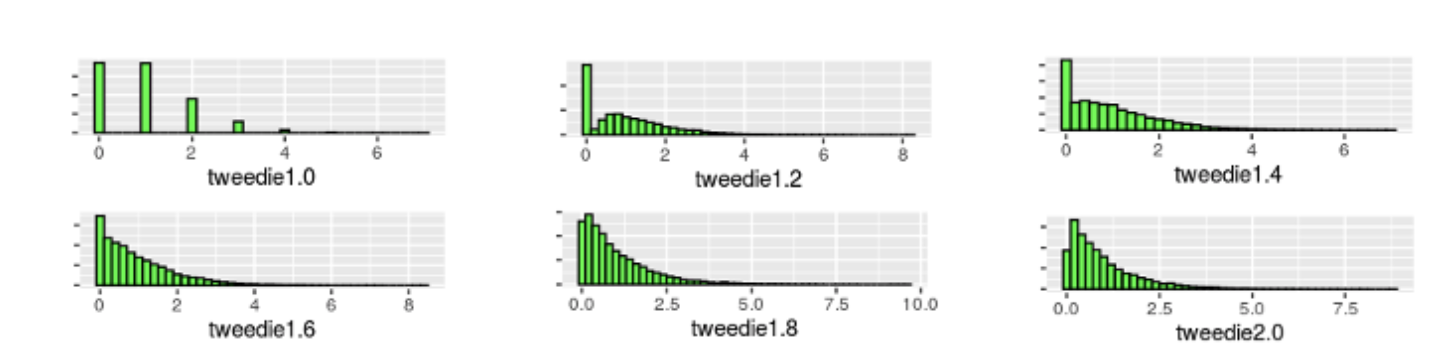



- **<font size="5">If you like the charts, give some love and upvote :) </font>**

In [ ]:
import plotly.io as pio
list(pio.templates)